In [1]:
!pip install opendatasets --quiet
!pip install kaggle --quiet

In [3]:
import opendatasets as opd

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Download dataset using Kaggle credentials
dataset_url = "https://www.kaggle.com/datasets/thienkhonghoc/affectnet/data"
opd.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  Sauravsoni941


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/thienkhonghoc/affectnet


In [6]:
# -----------------------------
# 1. Data Inspection and Preprocessing
# -----------------------------
# Define dataset directories
base_dir = "./affectnet/AffectNet"  # Root directory of the dataset
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

def count_images(directory):
    counts = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            counts[folder] = len(os.listdir(folder_path))
    return counts

print("Training set counts:", count_images(train_dir))
print("Validation set counts:", count_images(val_dir))
print("Test set counts:", count_images(test_dir))


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Training set counts: {'6': 5000, '4': 5000, '0': 5000, '5': 5000, '7': 3750, '2': 5000, '3': 5000, '1': 3803}
Validation set counts: {'6': 100, '4': 100, '0': 100, '5': 100, '7': 100, '2': 100, '3': 100, '1': 100}
Test set counts: {'6': 400, '4': 400, '0': 400, '5': 400, '7': 400, '2': 400, '3': 400, '1': 400}
Using device: cuda


In [7]:
# Image dimensions and hyperparameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 8

# Define transforms for train, validation, and test sets
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # Using ImageNet normalization values
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=test_val_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)





In [8]:
# -----------------------------
# 2. Define the CNN Model Architecture
# -----------------------------
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (img_height // 16) * (img_width // 16), 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=num_classes).to(device)
print(model)


EmotionCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): BatchNorm2d(25

In [9]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 30

# For tracking best model
best_val_acc = 0.0
best_model_path = "best_emotion_cnn_weights.pth"

# Lists for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


# -----------------------------
# 4. Training Loop
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")
    
    # Save the best model weights based on validation accuracy
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), best_model_path)

# Save the final model weights as well
final_model_path = "final_emotion_cnn_weights.pth"
torch.save(model.state_dict(), final_model_path)
print("Model training complete. Best weights saved at:", best_model_path)
print("Final model weights saved at:", final_model_path)



Epoch 1/30: Train Loss: 2.0680 Acc: 0.1555 | Val Loss: 2.0034 Acc: 0.2087
Epoch 2/30: Train Loss: 1.9811 Acc: 0.1887 | Val Loss: 1.8570 Acc: 0.2538
Epoch 3/30: Train Loss: 1.9173 Acc: 0.2259 | Val Loss: 1.7745 Acc: 0.2988
Epoch 4/30: Train Loss: 1.8525 Acc: 0.2528 | Val Loss: 1.7043 Acc: 0.3362
Epoch 5/30: Train Loss: 1.7998 Acc: 0.2802 | Val Loss: 1.6549 Acc: 0.3400
Epoch 6/30: Train Loss: 1.7693 Acc: 0.2921 | Val Loss: 1.6176 Acc: 0.3900
Epoch 7/30: Train Loss: 1.7292 Acc: 0.3204 | Val Loss: 1.5780 Acc: 0.3925
Epoch 8/30: Train Loss: 1.6543 Acc: 0.3580 | Val Loss: 1.4901 Acc: 0.4375
Epoch 9/30: Train Loss: 1.5832 Acc: 0.3941 | Val Loss: 1.4378 Acc: 0.4775
Epoch 10/30: Train Loss: 1.5176 Acc: 0.4220 | Val Loss: 1.4191 Acc: 0.4688
Epoch 11/30: Train Loss: 1.4773 Acc: 0.4400 | Val Loss: 1.4052 Acc: 0.4763
Epoch 12/30: Train Loss: 1.4429 Acc: 0.4537 | Val Loss: 1.3369 Acc: 0.5062
Epoch 13/30: Train Loss: 1.4009 Acc: 0.4727 | Val Loss: 1.3567 Acc: 0.5088
Epoch 14/30: Train Loss: 1.3791 Ac

In [10]:
# -----------------------------
# 5. Evaluation on Test Set
# -----------------------------
model.eval()
test_running_corrects = 0
test_running_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)

test_loss = test_running_loss / len(test_dataset)
test_acc = test_running_corrects.double() / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 1.3726, Test Accuracy: 0.5266


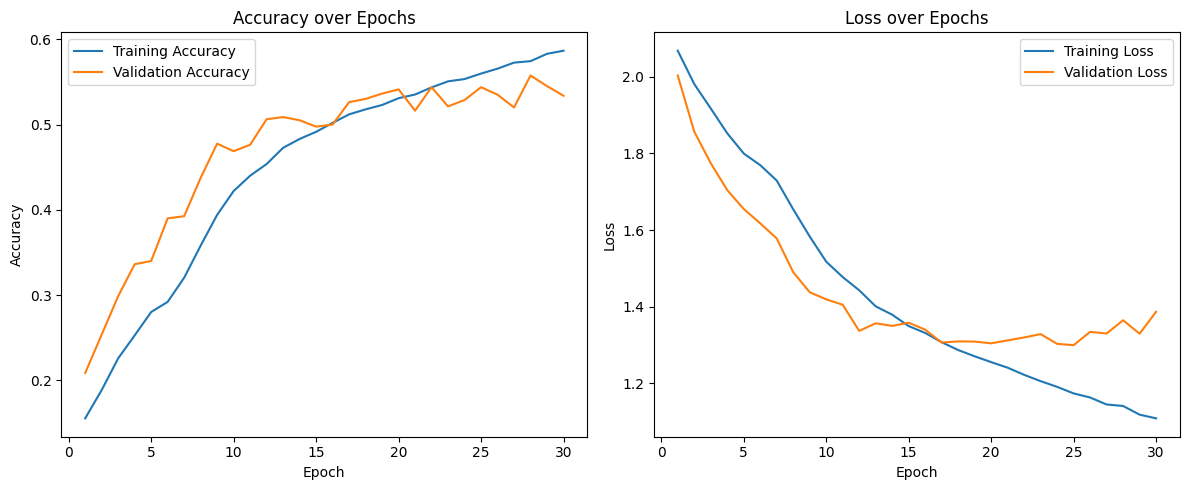

In [11]:
# -----------------------------
# 6. Visualizations
# -----------------------------
epochs_range = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()